# Backtesting and benchmarking of the trading strategies


In [ ]:
import os
import sys

In [ ]:
REPO_ROOT = "/Users/ingridperez/Documents/GitHub Repositiories/xdl-portfolio"
sys.path.append(REPO_ROOT)

In [ ]:
import pandas as pd

from agents.drl_agent import DRLAgent
from config import config, config_models
from environments.env_portfolio_optimisation import (
    PortfolioOptimisationEnvWrapper,
)
from environments.env_stock_trading import StockTradingEnvWrapper
from pbenchmark.portfolio_benchmark import PortfolioBenchmark
from preprocessor.findata_preprocessor import FinancialDataPreprocessor
from visualiser.benchmark_visualiser import BenchmarkVisualiser

In [ ]:
USE_CASE = "portfolio-optimisation"

In [ ]:
data_dir = f"{REPO_ROOT}/{config.DATA_DIR}/{config.DATASET_NAME}"
plot_dir = f"{REPO_ROOT}/{config.PLOT_DIR}/{config.TICKERS_NAME}/{config.DATASET_NAME}/{USE_CASE}"
models_dir = f"{REPO_ROOT}/{config.MODELS_DIR}/{USE_CASE}/{config.TICKERS_NAME}/{config.DATASET_NAME}"
results_dir = (
    f"{REPO_ROOT}/{config.RESULTS_DIR}/{USE_CASE}/{config.DATASET_NAME}"
)

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [ ]:
finpreprocessor = FinancialDataPreprocessor(
    start_date=config.START_DATE,
    end_date=config.END_DATE,
)
train_data, trade_data = finpreprocessor.load_train_test_data(
    directory=data_dir,
    filename=config.TICKERS_NAME,
)

In [ ]:
if USE_CASE == "stock-trading":
    environment = StockTradingEnvWrapper(
        train_data=train_data,
        trade_data=trade_data,
        state_columns=config.ENVIRONMENT_COLUMNS,
    )
elif USE_CASE == "portfolio-optimisation":
    environment = PortfolioOptimisationEnvWrapper(
        train_data=train_data,
        trade_data=trade_data,
        state_columns=config.ENVIRONMENT_COLUMNS,
    )

Environment successfully created with 
	Stock dimension: 30 
	State space: 18


## Backtest the algorithms


In [ ]:
benchmark = PortfolioBenchmark()

In [ ]:
df_account = pd.DataFrame()
perf_stats = dict()

for model_name in config_models.MODELS.keys():

    env_train = environment.get_train_env()
    gym_env, _ = environment.get_trade_env()

    agent = DRLAgent()

    print(f"Loading model: {model_name.upper()}")
    trained_model = agent.load_model(
        model_name=model_name,
        directory=models_dir,
    )

    print(f"Evaluating model: {model_name.upper()}")
    df_account_alg, _ = agent.predict(
        model=trained_model,
        environment=gym_env,
    )

    df_account_alg["model"] = model_name.upper()

    df_account = pd.concat([df_account, df_account_alg], ignore_index=True)

    perf_stats_alg = benchmark.compute_perf_stats(df_account=df_account_alg)

    perf_stats[model_name.upper()] = perf_stats_alg

Loading model: A2C
Model successfully loaded from /Users/ingridperez/Documents/GitHub Repositiories/xdl-portfolio/models/portfolio-optimisation/dow30/dataset-indicators/a2c
Evaluating model: A2C
Loading model: PPO
Model successfully loaded from /Users/ingridperez/Documents/GitHub Repositiories/xdl-portfolio/models/portfolio-optimisation/dow30/dataset-indicators/ppo
Evaluating model: PPO
Loading model: DDPG
Model successfully loaded from /Users/ingridperez/Documents/GitHub Repositiories/xdl-portfolio/models/portfolio-optimisation/dow30/dataset-indicators/ddpg
Evaluating model: DDPG
Loading model: TD3
Model successfully loaded from /Users/ingridperez/Documents/GitHub Repositiories/xdl-portfolio/models/portfolio-optimisation/dow30/dataset-indicators/td3
Evaluating model: TD3
Loading model: SAC
Model successfully loaded from /Users/ingridperez/Documents/GitHub Repositiories/xdl-portfolio/models/portfolio-optimisation/dow30/dataset-indicators/sac
Evaluating model: SAC


In [ ]:
benchmark.set_data(
    train_data=train_data,
    trade_data=trade_data,
)

Test start date is not a trading date in the dataset.
Using next available trading date: 2024-01-02


In [ ]:
for strategy in ["mean", "min", "momentum", "equal"]:
    print(f"Optimising portfolio with strategy: {strategy}")

    df_account_strat = benchmark.optimise_portfolio(
        strategy=strategy,  # type: ignore
    )

    # Add cumulative returns to the account dataframe
    df_account_strat["cumulative_return"] = (
        1 + df_account_strat["daily_return"]
    ).cumprod() - 1

    df_account_strat["model"] = strategy.capitalize()
    df_account = pd.concat([df_account, df_account_strat], ignore_index=True)  # type: ignore

    perf_stats_alg = benchmark.compute_perf_stats(df_account=df_account_strat)
    perf_stats[strategy.capitalize()] = perf_stats_alg

Optimising portfolio with strategy: mean
Optimising portfolio with strategy: min
Optimising portfolio with strategy: momentum
Optimising portfolio with strategy: equal


In [ ]:
perf_stats = pd.DataFrame(perf_stats)
perf_stats.to_csv(
    f"{results_dir}/{config.TICKERS_NAME}_performance_stats.csv",
    index=True,
)

In [ ]:
perf_stats

,A2C,PPO,DDPG,TD3,SAC,Mean,Min,Momentum,Equal
Annual return,0.202705,0.225654,0.212492,0.183340,0.179858,0.321841,0.112253,0.385529,0.206633
Cumulative returns,0.315122,0.352536,0.331036,0.283819,0.278216,0.511348,0.170546,0.620368,0.320517
Annual volatility,0.151186,0.149647,0.149020,0.152842,0.152837,0.183898,0.115666,0.198973,0.147631
Sharpe ratio,1.296311,1.434464,1.367469,1.177677,1.158214,1.609546,0.977684,1.738824,1.346071
Calmar ratio,1.283622,1.428888,1.377033,1.153476,1.144710,1.623275,1.052849,1.998474,1.340914
Stability,0.784094,0.804316,0.852386,0.773507,0.738245,0.587368,0.659270,0.665404,0.797902
Max drawdown,-0.157916,-0.157923,-0.154311,-0.158945,-0.157121,-0.198267,-0.106618,-0.192912,-0.154098
Omega ratio,1.282344,1.312892,1.299855,1.252982,1.253597,1.328869,1.196714,1.361720,1.296735
Sortino ratio,1.957431,2.187117,2.045296,1.757864,1.752345,2.473286,1.416733,2.686275,2.026772
Skew,0.760368,0.857999,0.649858,0.666118,1.113600,0.320789,-0.113775,0.254478,0.758244


## Visually compare portfolio value and cumulative returns


In [ ]:
benchmark_visualiser = BenchmarkVisualiser(directory=plot_dir)

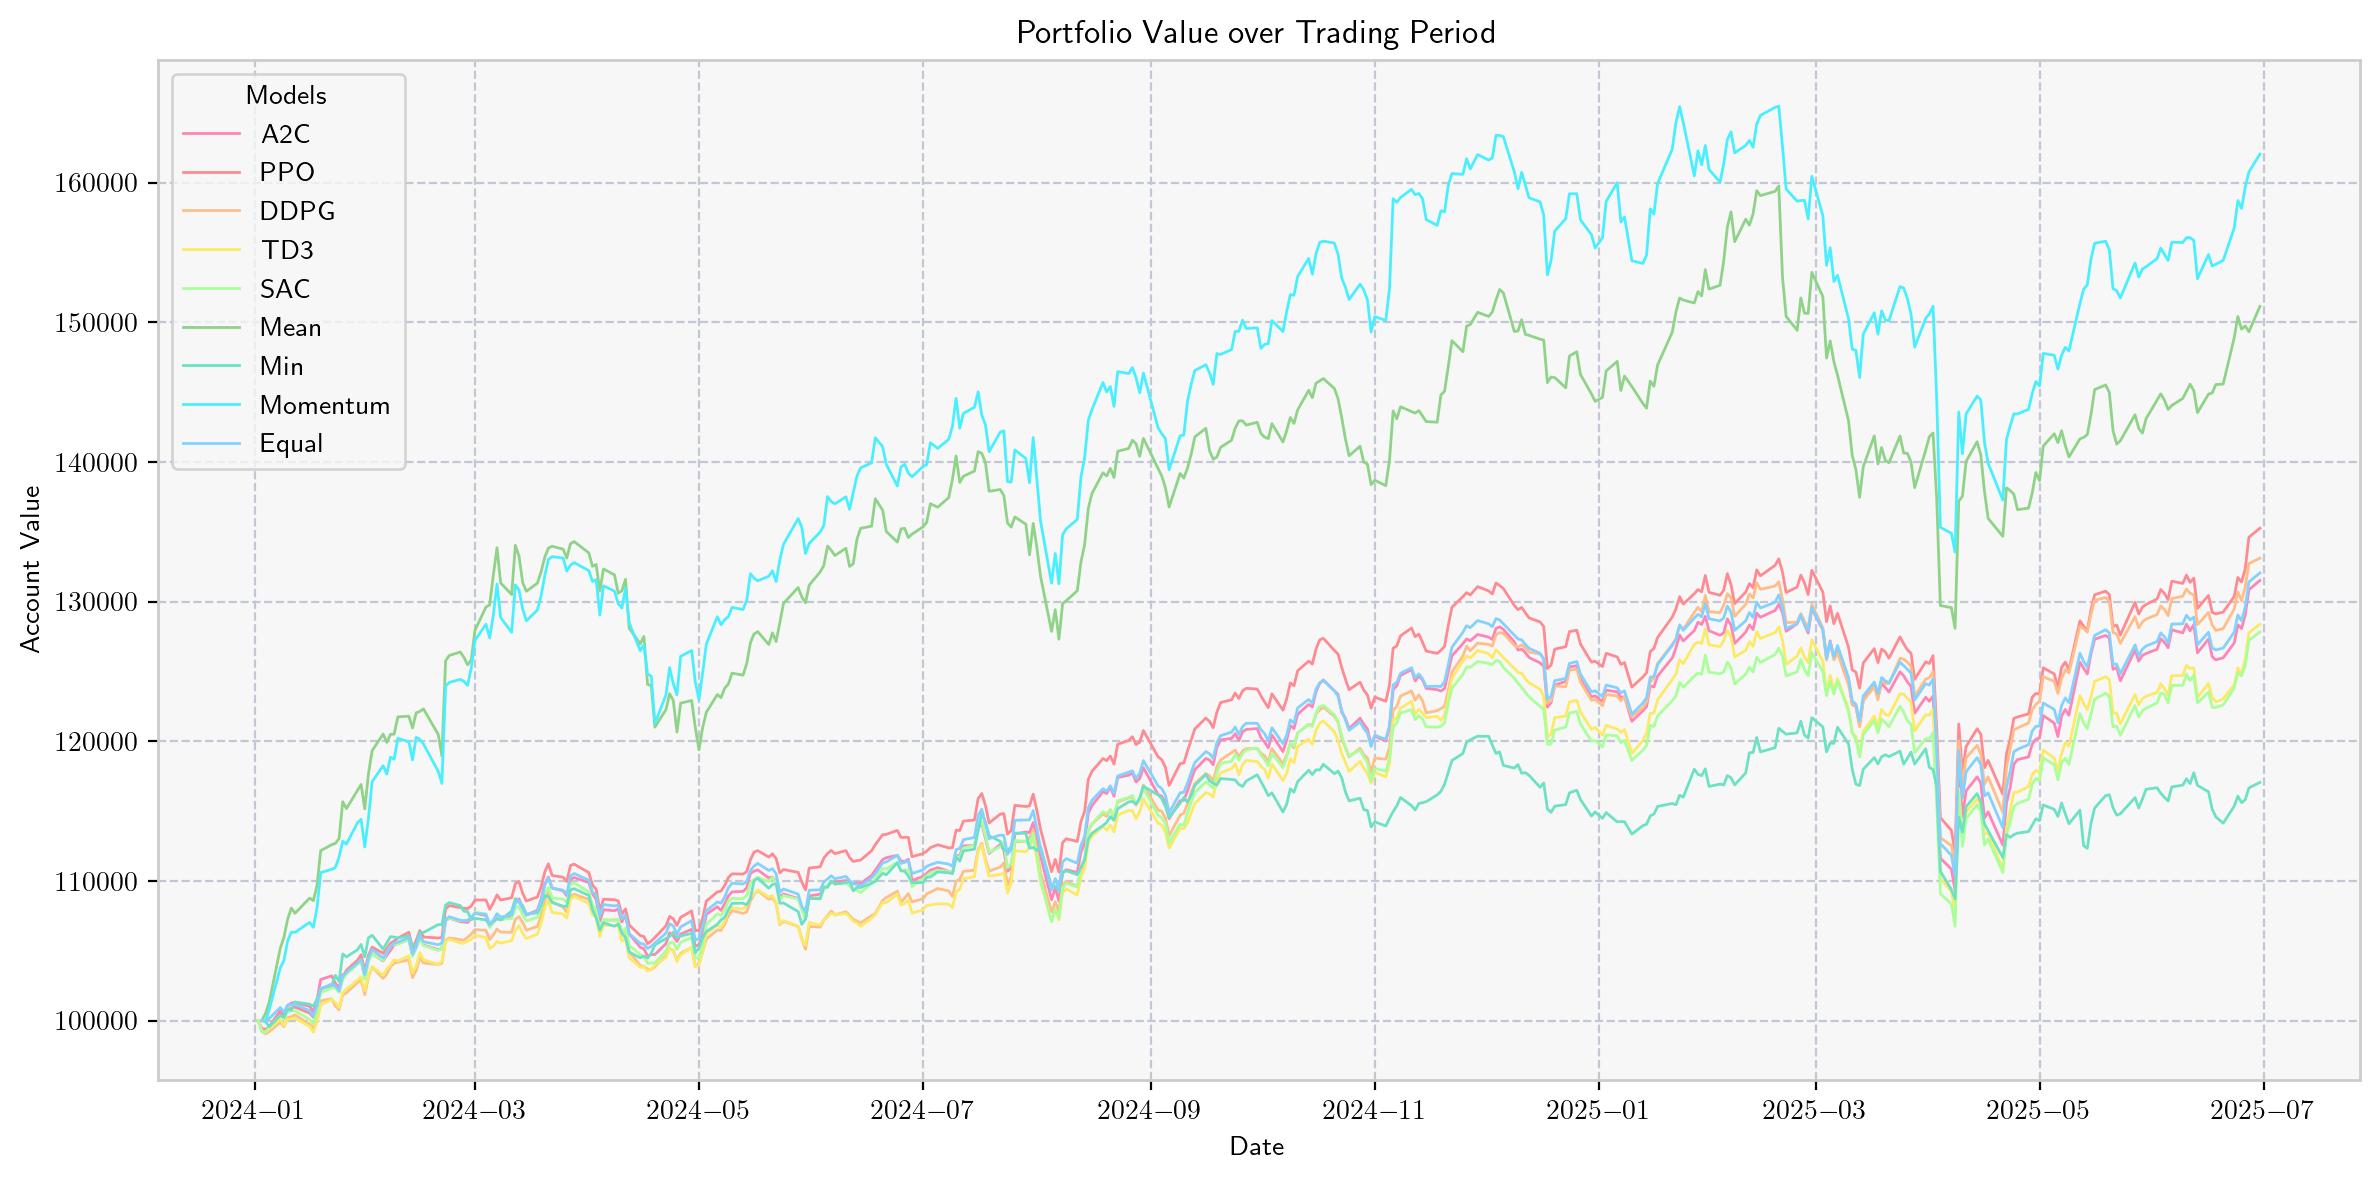

In [ ]:
benchmark_visualiser.compare_account_value(data=df_account)

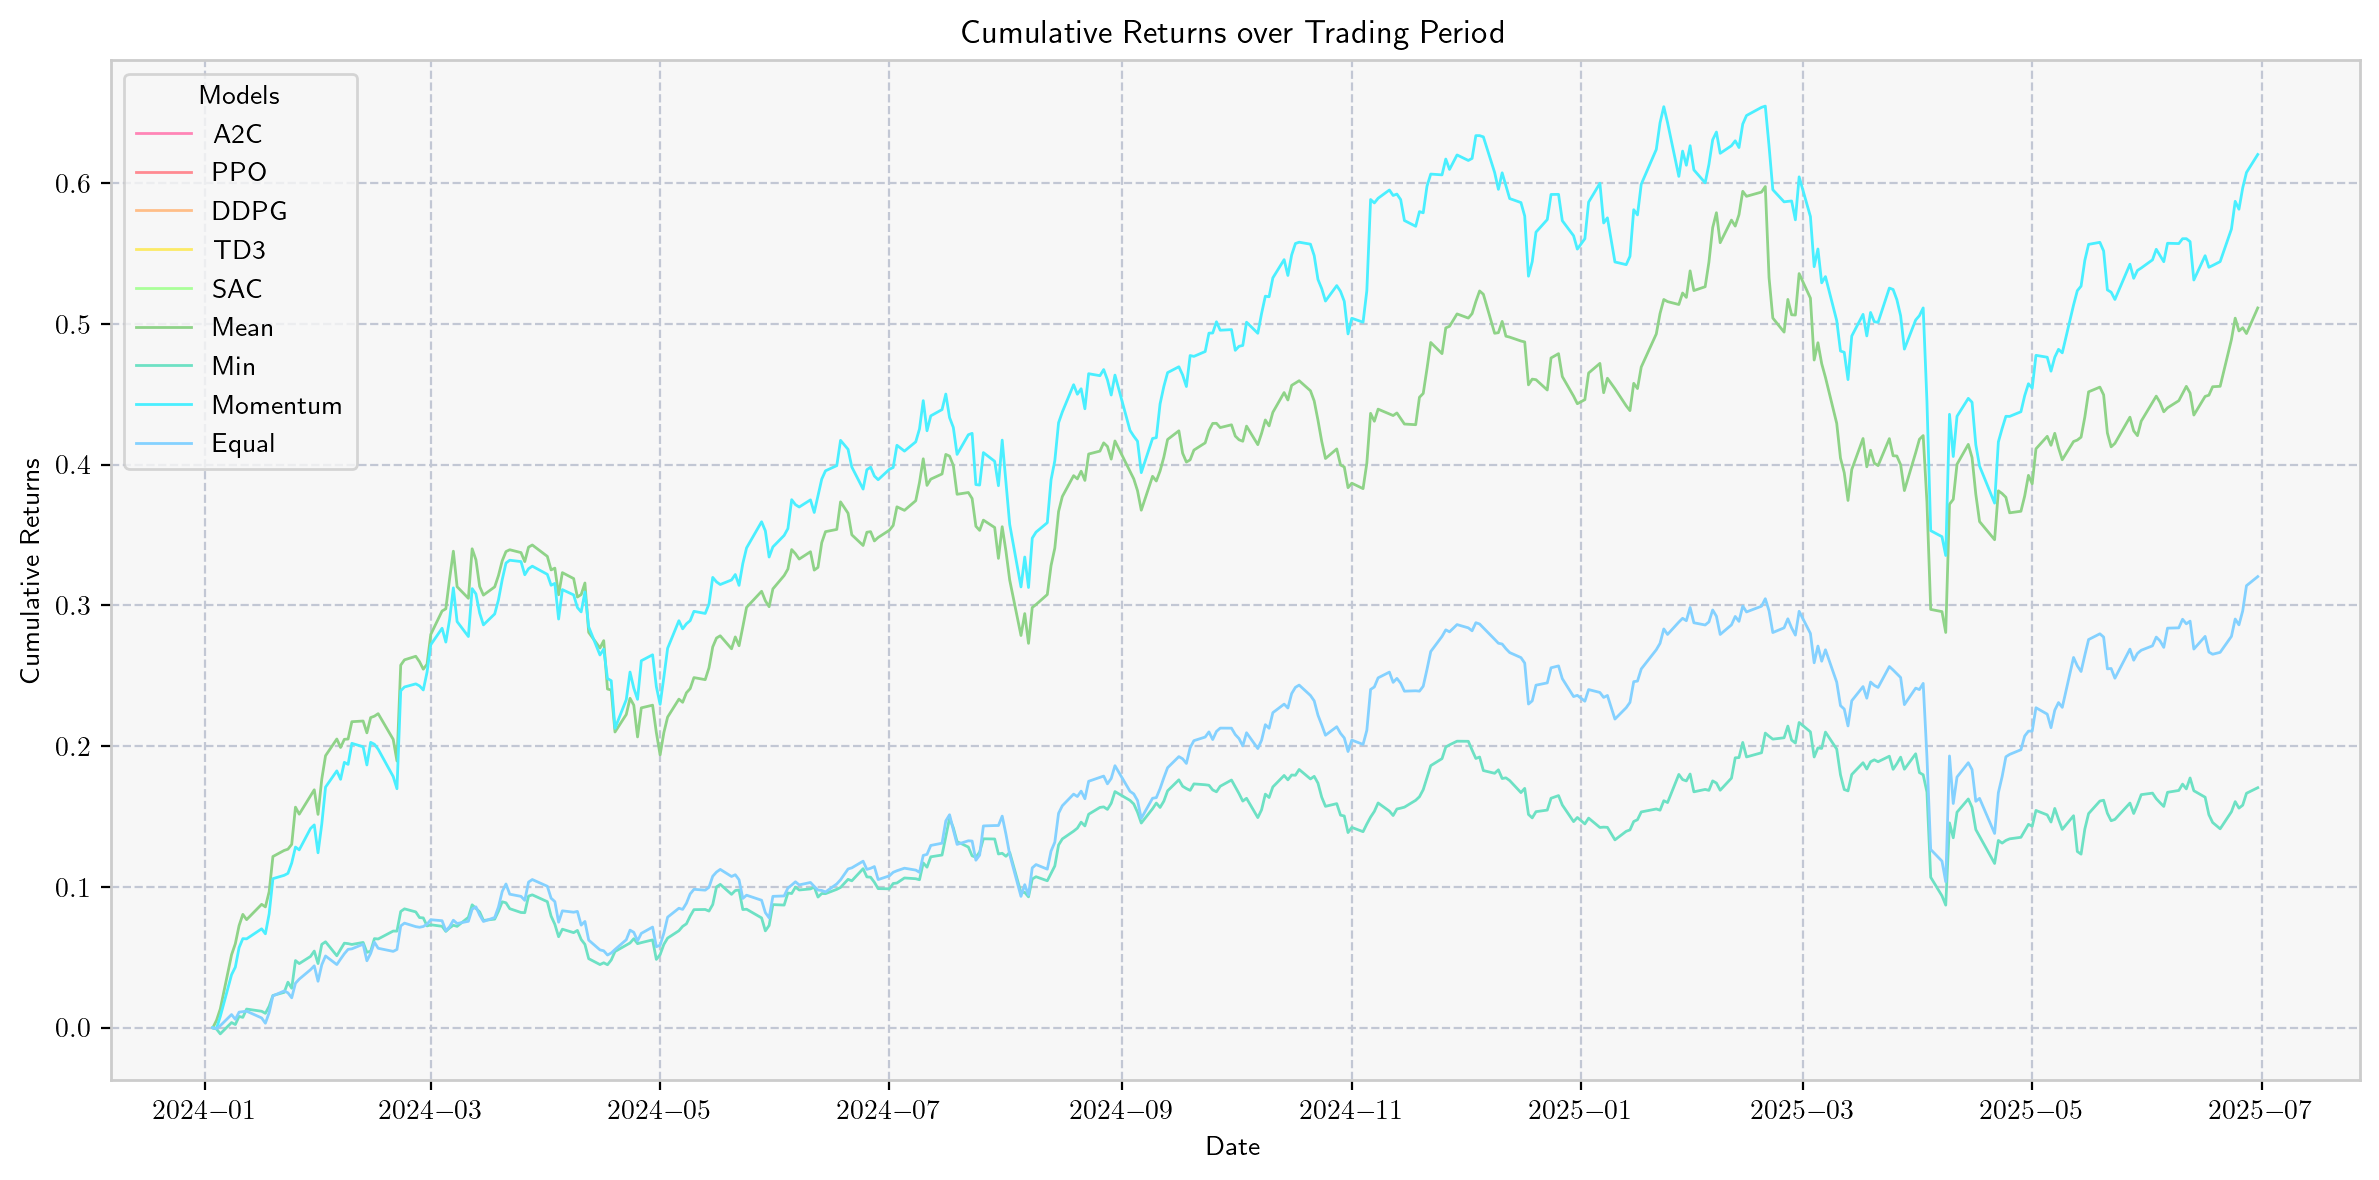

In [16]:
benchmark_visualiser.compare_cum_returns(data=df_account)